In [1]:
%matplotlib inline


# LDA Model

Introduces Gensim's LDA model and demonstrates its use on the NIPS corpus.


In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [4]:
import json
dataset_path = "/home/ralf/IdeaProjects/LitBall-training/EXP-Title+TLDR/"
text_key = "preprocessedText"
docs = []
with open(dataset_path + "ROTVRSV") as file:
    lines = file.readlines()
    for line in lines:
        d = json.loads(line)
        docs.append(d[text_key])

tdocs = []
with open(dataset_path + "DENV") as file:
    lines = file.readlines()
    for line in lines:
        d = json.loads(line)
        tdocs.append(d[text_key])

        # Tokenize the documents.

        from nltk.tokenize import RegexpTokenizer

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.
for idx in range(len(tdocs)):
    tdocs[idx] = tdocs[idx].lower()  # Convert to lowercase.
    tdocs[idx] = tokenizer.tokenize(tdocs[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]
tdocs = [[token for token in doc if not token.isnumeric()] for doc in tdocs]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]
tdocs = [[token for token in doc if len(token) > 1] for doc in tdocs]

# Compute bigrams.
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=5)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
for idx in range(len(tdocs)):
    for token in bigram[tdocs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            tdocs[idx].append(token)

print(len(docs))
print(docs[0][:500])
print(len(tdocs))
print(tdocs[0][:500])

22996
['carbocisteine', 'inhibit', 'respiratory', 'syncytial', 'virus', 'infection', 'human', 'tracheal', 'epithelial', 'cell', 'it', 'be', 'suggest', 'carbocisteine', 'may', 'inhibit', 'rs', 'virus', 'infection', 'reduce', 'expression', 'icam', 'rs', 'virus', 'receptor', 'it', 'may', 'also', 'modulate', 'airway', 'inflammation', 'rsirus', 'infection', 'respiratory_syncytial', 'tracheal_epithelial', 'it_be', 'rs_virus', 'rs_virus', 'airway_inflammation']
8679
['vitro', 'effect', 'human', 'cathelicidin', 'antimicrobial', 'peptide', 'll', 'dengue', 'virus', 'type', 'vitro', 'experiment', 'silico', 'analysis', 'suggest', 'll', 'inhibit', 'dengue', 'virus', 'type', 'denv', 'infection', 'replication', 'vero', 'e6', 'cell', 'bind', 'protein', 'antimicrobial_peptide', 'dengue_virus', 'silico_analysis', 'dengue_virus', 'vero_e6']


In [5]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)
bads = ["in", "it", "may", "also", "that", "which", "will", "not", "have", "use"]
dictionary.filter_tokens(bad_ids=[dictionary.token2id[tok] for tok in bads])

# Bag-of-words representation of the documents.
tr_corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(tr_corpus))
te_corpus = [dictionary.doc2bow(doc) for doc in tdocs]
print('Number of test documents: %d' % len(te_corpus))
print(te_corpus[500])

Number of unique tokens: 4155
Number of documents: 22996
Number of test documents: 8679
[(7, 1), (21, 1), (38, 3), (75, 1), (253, 1), (260, 1), (282, 1), (467, 1), (497, 2), (516, 1), (534, 1), (584, 1), (714, 1), (748, 1), (951, 1), (952, 1), (955, 1), (1458, 1), (1507, 1), (1682, 1), (2248, 3), (2550, 1), (2827, 1), (3115, 1)]


In [14]:
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
num_topics = 100
chunksize = 2000
passes = 30
iterations = 1000
eval_every = None  # Don't evaluate model perplexity, takes too much time.
corpus = tr_corpus

# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

In [15]:
top_topics = model.top_topics(corpus)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

Average topic coherence: -9.5485.
[([(0.24092528, 'virus'),
   (0.14978474, 'infection'),
   (0.12322804, 'viral'),
   (0.049532883, 'host'),
   (0.039612584, 'human'),
   (0.03461366, 'mechanism'),
   (0.034596376, 'it_be'),
   (0.034362346, 'study'),
   (0.030372797, 'can'),
   (0.024395257, 'factor'),
   (0.024107846, 'suggest'),
   (0.020738747, 'other'),
   (0.018214434, 'influenza'),
   (0.015249239, 'involve'),
   (0.014066593, 'control'),
   (0.013590012, 'reveal'),
   (0.012805346, 'find'),
   (0.012114758, 'identify'),
   (0.011478184, 'antiviral'),
   (0.011472656, 'require')],
  -2.803629146120294),
 ([(0.12257289, 'pathway'),
   (0.08824568, 'signaling'),
   (0.08252886, 'mediate'),
   (0.07888453, 'activation'),
   (0.048943724, 'induce'),
   (0.04188155, 'dependent'),
   (0.03999817, 'activate'),
   (0.02895397, 'apoptosis'),
   (0.026302258, 'macrophage'),
   (0.02292152, 'inhibit'),
   (0.022348223, 'autophagy'),
   (0.022086563, 'signaling_pathway'),
   (0.020725787, 

In [16]:
farr1 = []
for i in range(len(docs)):
    arr = [0.0] * num_topics
    for t,w in model[tr_corpus[i]]:
        arr[t] = w
    farr1.append(arr)
farr2 = []
for i in range(len(tdocs)):
    arr = [0.0] * num_topics
    for t,w in model[te_corpus[i]]:
        arr[t] = w
    farr2.append(arr)
print(model[te_corpus[1]])
print(farr2[1])
print(len(farr1))
print(len(farr2))

[(1, 0.031901505), (2, 0.032649495), (5, 0.05929768), (12, 0.015913889), (13, 0.016996084), (21, 0.03571517), (25, 0.01842341), (29, 0.039008617), (31, 0.059833102), (36, 0.030425683), (38, 0.050427504), (46, 0.08612031), (49, 0.030352775), (52, 0.01611218), (53, 0.016891291), (54, 0.031312086), (62, 0.015344467), (64, 0.046127897), (75, 0.036973577), (81, 0.030929333), (82, 0.016635317), (85, 0.020762367), (87, 0.02218344), (88, 0.048628215), (89, 0.031078858), (98, 0.015710741)]
[0.0, 0.0318992, 0.032646216, 0.0, 0.0, 0.05929768, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01597834, 0.016996084, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.035708696, 0.0, 0.0, 0.0, 0.018423457, 0.0, 0.0, 0.0, 0.039005436, 0.0, 0.059833102, 0.0, 0.0, 0.0, 0.0, 0.030425683, 0.0, 0.050387572, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08612179, 0.0, 0.0, 0.030352775, 0.0, 0.0, 0.01611218, 0.016889097, 0.031312086, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.015344467, 0.0, 0.046127897, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [17]:
# Load the dataset
import tensorflow_datasets as tfds
import tensorflow as tf
import pandas as pd
import tensorflow_decision_forests as tfdf
import numpy as np

bsize = 300
larr1 = []
larr2 = []
with open(dataset_path + "ROTVRSV") as file:
    lines = file.readlines()
    for line in lines:
        d = json.loads(line)
        larr1.append(int(d["label"]))
train_ds = tf.data.Dataset.from_tensor_slices((np.asarray(farr1), 
                                               np.asarray(larr1))).batch(bsize)

with open(dataset_path + "DENV") as file:
    test_lines = file.readlines()
    for line in test_lines:
        d = json.loads(line)
        larr2.append(int(d["label"]))
test_ds = tf.data.Dataset.from_tensor_slices((np.asarray(farr2),
                                              np.asarray(larr2))).batch(bsize)
print("Made datasets")

Made datasets


In [22]:
# Specify the model.
model_1 = tfdf.keras.RandomForestModel(num_trees=1000, num_threads=3)

# Train the model.
model_1.fit(x=train_ds, batch_size=None)

Use /tmp/tmpt7jd3xve as temporary training directory


Reading training dataset...
Training dataset read in 0:00:00.673473. Found 22996 examples.
Training model...


[INFO 23-07-18 19:03:34.4788 CEST kernel.cc:1243] Loading model from path /tmp/tmpt7jd3xve/model/ with prefix 9d332aaf60a94bb6


Model trained in 0:00:33.709200
Compiling model...


[INFO 23-07-18 19:03:38.6242 CEST decision_forest.cc:660] Model loaded with 1000 root(s), 1458208 node(s), and 100 input feature(s).
[INFO 23-07-18 19:03:38.6242 CEST abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-18 19:03:38.6243 CEST kernel.cc:1075] Use fast generic engine
2023-07-18 19:03:38.982923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [22996]
	 [[{{node Placeholder/_1}}]]


Model compiled.


In [23]:
model_1.compile(metrics=["accuracy"])
evaluation = model_1.evaluate(test_ds, batch_size=None)

print(f"BinaryCrossentropyloss: {evaluation[0]}")
print(f"Accuracy: {evaluation[1]}")

29/29 [==============================] - 1s 33ms/step - loss: 0.0000e+00 - accuracy: 0.8262
BinaryCrossentropyloss: 0.0
Accuracy: 0.8262472748756409


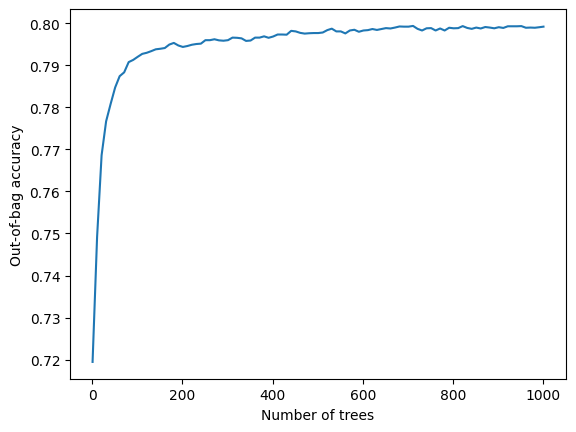

In [24]:
import matplotlib.pyplot as plt

logs = model_1.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Out-of-bag accuracy")
pass

In [25]:
p = model_1.predict(test_ds)

#Fish for best cut
for cut in np.arange(0.25, .8, .05):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    N = len(p)
    for i in range(N):
        tru = larr2[i] == 1
        prd = p[i] > cut
        if tru and prd == tru:
            tp = tp + 1
        if tru and prd != tru:
            fn = fn + 1
        if tru == False and prd == tru:
            tn = tn + 1
        if tru == False and prd != tru:
            fp = fp + 1
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    print("cut: {}, acc: {}, prec: {}, rec: {}, f1: {}".format(cut, (tp+tn)/N, precision, recall, f1_score))

29/29 [==============================] - 1s 33ms/step
cut: 0.25, acc: 0.6682797557322272, prec: 0.4363490792634107, rec: 0.9719126170307624, f1: 0.6022931344108302
cut: 0.3, acc: 0.7121788224449821, prec: 0.4718480900861117, rec: 0.9527418635755684, f1: 0.6311281748375664
cut: 0.35, acc: 0.7490494296577946, prec: 0.5079287631129544, rec: 0.9282211324119483, f1: 0.6565752128666037
cut: 0.39999999999999997, acc: 0.7811959903214656, prec: 0.54638619201726, rec: 0.903254569772626, f1: 0.680893967400437
cut: 0.44999999999999996, acc: 0.8051618850097938, prec: 0.5829326923076923, rec: 0.8649130628622381, f1: 0.6964638305510681
cut: 0.49999999999999994, acc: 0.826247263509621, prec: 0.6234464225730602, rec: 0.8274632189032546, f1: 0.7111111111111111
cut: 0.5499999999999999, acc: 0.8393824173291854, prec: 0.6606129398410897, rec: 0.7784217565760143, f1: 0.7146950470732707
cut: 0.5999999999999999, acc: 0.8504435994930292, prec: 0.7041036717062635, rec: 0.7267053053945609, f1: 0.715225976305397
